In [1]:
import jax
import jax.numpy as jnp

from lagrangian_ot import geometries, data, lagrangian_potentials
import warnings
warnings.filterwarnings('ignore')

import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns

from ott.neural.methods.flows.dynamics import ConstantNoiseFlow, LagrangianFlow, BrownianBridge, LagrangianBridgeFlow
key = jax.random.PRNGKey(42)

In [2]:
def sample_ode(model, x0, num_steps):
    dt = jnp.ones((x0.shape[0], 1)) / num_steps
    dsdx = jax.jit(jax.grad(lambda p, x, t: model.apply_fn(p, x, t).sum(), argnums=1))

    def ode_run(carry, _):
        x0, step = carry
        cur_t = dt * step
        pred = dsdx(model.params, x0, cur_t)
        x0 = x0 + pred * dt
        return (x0, step+1), x0
    
    trajs = jax.lax.scan(ode_run, init=(x0, 1), length=num_steps)[1]
    return jnp.concatenate([x0[None], trajs], axis=0)

def draw_trajs(trajs, ax=None):
    with plt.style.context(['science', 'notebook']):
        if ax is None:
            fig, ax = plt.subplots()
        colors = sns.color_palette("pastel", trajs.shape[1])
        
        for point in range(trajs.shape[1]):
            for t in range(1, trajs.shape[0]):
                ax.plot([trajs[t-1, point, 0], trajs[t, point, 0]],
                        [trajs[t-1, point, 1], trajs[t, point, 1]],
                        color=colors[point], linestyle="-", linewidth=1, marker='o', alpha=0.6, markersize=1)
        ax.grid(True)
        plt.show()

In [3]:
DATASET = "lsb_box"

geometry_kwargs = {"spline_solver_kwargs":{
    "num_spline_nodes": 30,
    "grad_tol": 1e-5,
    "init_lr": 1e-3,
    "num_spline_points_eval": 20,
    "max_iter": 0}}
geometry = geometries.get(DATASET, geometry_kwargs)
source_sampler, target_sampler = data.get_samplers(DATASET, 128, key)
potential = lagrangian_potentials.BoxPotential()
params_potential = potential.init(key, jnp.ones((2, )))

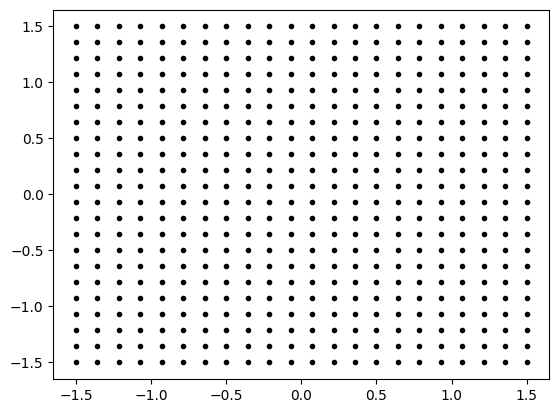

In [4]:
xs = jnp.linspace(start=-1.5, stop=1.5, num=22)
xx, yy = jnp.meshgrid(xs, xs)

fig, ax = plt.subplots()
ax.plot(xx, yy, marker='.', linestyle='none', color='k')
plt.show()

In [5]:
inp = jnp.vstack([xx.ravel(), yy.ravel()]).T

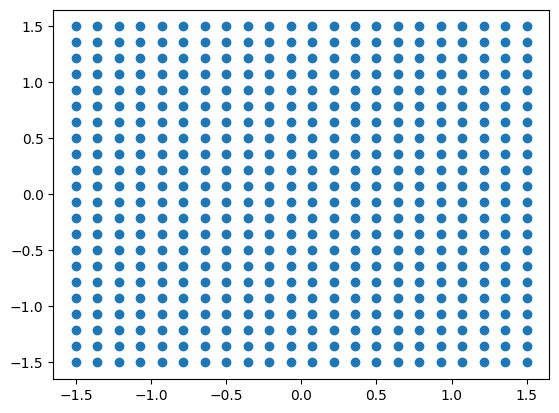

In [6]:
plt.scatter(inp[:,0], inp[:, 1])
plt.show()

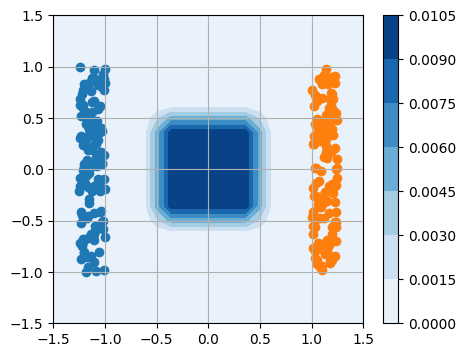

In [7]:
countours = jax.vmap(potential.apply, in_axes=(None, 0))(params_potential, inp)

fig, ax = plt.subplots(figsize=(5, 4))
source_data = next(source_sampler)
target_data = next(target_sampler)

plt.contourf(xx, yy, -countours.reshape(xx.shape), cmap="Blues")
plt.colorbar()
ax.scatter(source_data[:, 0], source_data[:, 1])
ax.scatter(target_data[:, 0], target_data[:, 1])
plt.grid()
plt.show()

In [8]:
from functools import partial
import jax

class DatasetLoader:
    def __init__(self, size):
        self.size = size

    def __iter__(self):
        rng = jax.random.PRNGKey(42)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield DatasetLoader._sample(sample_key, self.size)

    @staticmethod
    @partial(jax.jit, static_argnums=(1,))
    def _sample(key, batch_size):
        k1, k2, key = jax.random.split(key, 3)
        x1 = jax.random.uniform(k1, (batch_size, 1), minval=-1.25, maxval=-1.0)
        x2 = jax.random.uniform(k2, (batch_size, 1), minval=-1.0, maxval=1.0)
        x_0 = jnp.concatenate([x1, x2], axis=1)
        
        k1, k2, key = jax.random.split(key, 3)
        x1 = jax.random.uniform(k1, (batch_size, 1), minval=1, maxval=1.25)
        x2 = jax.random.uniform(k2, (batch_size, 1), minval=-1.0, maxval=1.0)
        x_1 = jnp.concatenate([x1, x2], axis=1)

        return {
            "src_lin": x_0,
            "tgt_lin": x_1
        }

# Action Matching

In [9]:
from tqdm.auto import tqdm
from flax.training import train_state
import optax
import flax.linen as nn

class MLP(nn.Module):
    hidden_layers: list
    
    @nn.compact
    def __call__(self, x, t):
        x = jnp.concatenate([x, t], -1)
        for i, dim in enumerate(self.hidden_layers):
            x = nn.Dense(dim)(x)
            if i != len(self.hidden_layers) - 1:
                x = nn.swish(x)
        return x
    
net = MLP(hidden_layers=[128, 128, 128, 128, 1])
params = net.init(jax.random.PRNGKey(42), jnp.ones((1, 2)), jnp.ones((1, 1)))

state = train_state.TrainState.create(
    params=params,
    tx=optax.adam(learning_rate=2e-4),
    apply_fn=net.apply
)

dsdxdt = jax.grad(lambda params, x, t: state.apply_fn(params, x, t).sum(), argnums=[1, 2])

@jax.jit
def train_step(state, t, x_t, pi0, pi1, U_t):
    
    def loss_fn(params):
        initial = state.apply_fn(params, pi0, jnp.zeros((pi0.shape[0], 1)))
        final = state.apply_fn(params, pi1, jnp.ones((pi1.shape[0], 1)))
        dsdx, dsdt = dsdxdt(params, x_t, t)
        loss = initial - final + 0.5 * ((dsdx) ** 2).sum(1, keepdims=True) + dsdt + U_t
        return loss.mean()
    
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss

batch_size = 512
num_epochs = 25_000
key = jax.random.PRNGKey(42)
ds = iter(DatasetLoader(batch_size))
potential = lagrangian_potentials.BoxPotential()
params_potential = potential.init(key, jnp.ones((2, )))

for epoch in tqdm(range(num_epochs)):
    key, sample_key, perm_key = jax.random.split(key, 3)
    
    pi0 = next(ds)['src_lin']
    pi1 = next(ds)['tgt_lin']

    t = jax.random.uniform(key=sample_key, shape=(pi0.shape[0], 1))
    x_t = (1 - t) * pi0 + t * pi1
    U_t = -jax.vmap(potential.apply, in_axes=(None, 0))(params_potential, x_t)
    state, loss = train_step(state, t, x_t, pi0, pi1, U_t)
    
    if (epoch + 1) % 1_000 == 0:
        print(f'Loss[{epoch+1:5d}/{num_epochs:5d}]: {loss}')

  0%|          | 0/25000 [00:00<?, ?it/s]

Loss[ 1000/25000]: -2.593722343444824
Loss[ 2000/25000]: -2.6211531162261963
Loss[ 3000/25000]: -2.582021474838257
Loss[ 4000/25000]: -2.595592498779297
Loss[ 5000/25000]: -2.5964958667755127
Loss[ 6000/25000]: -2.571460723876953
Loss[ 7000/25000]: -2.6248536109924316
Loss[ 8000/25000]: -2.5722498893737793
Loss[ 9000/25000]: -2.5873286724090576
Loss[10000/25000]: -2.6136937141418457
Loss[11000/25000]: -2.5716938972473145
Loss[12000/25000]: -2.534970283508301
Loss[13000/25000]: -2.576094627380371
Loss[14000/25000]: -2.610659599304199
Loss[15000/25000]: -2.067457437515259
Loss[16000/25000]: -2.4463698863983154
Loss[17000/25000]: -2.696810722351074
Loss[18000/25000]: -2.270254611968994
Loss[19000/25000]: -2.682455062866211
Loss[20000/25000]: -2.598621368408203
Loss[21000/25000]: -2.9437732696533203
Loss[22000/25000]: -1.5111722946166992
Loss[23000/25000]: -2.519317626953125
Loss[24000/25000]: -2.6859326362609863
Loss[25000/25000]: -2.4234206676483154


In [9]:
flow=LagrangianFlow(sigma=0.2, potential=potential)
                    
def draw_trajs(trajs, ax=None):
    with plt.style.context(['science', 'notebook']):
        if ax is None:
            fig, ax = plt.subplots()
        colors = sns.color_palette("pastel", trajs.shape[1])
        
        for point in range(trajs.shape[1]):
            for t in range(1, trajs.shape[0]):
                ax.plot([trajs[t-1, point, 0], trajs[t, point, 0]],
                        [trajs[t-1, point, 1], trajs[t, point, 1]],
                        color=colors[point], linestyle="-", linewidth=1, marker='o', alpha=0.6, markersize=1)
        ax.grid(True)
        plt.show()
        
trajs = sample_ode(state, pi0, 20)
with plt.style.context(['science', 'notebook']):
    fig, ax = plt.subplots()
    countours = flow.compute_potential(jnp.zeros_like(inp), inp) #jax.vmap(potential.apply, in_axes=(None, 0))(params_potential, inp)
    ax.contourf(xx, yy, countours.reshape(xx.shape), cmap="Blues")
    ax.scatter(pi0[:,0], pi0[:, 1], c='red', alpha=1, s=4, label='moons')
    ax.scatter(pi1[:,0], pi1[:, 1], c='black', alpha=0.5, s=10, label='gauss')
    ax.set_xlim((-1.5, 1.5))
    ax.set_ylim((-1.5, 1.5))
    draw_trajs(trajs=trajs, ax=ax)
    #countours = jax.vmap(jax.vmap(potential.apply, in_axes=(None, 0)), in_axes=(None, 0))(params_potential, trajs)
    ax.legend()
    plt.show()

NameError: name 'state' is not defined

# NOCC

In [26]:
from ott.neural.methods.flows.dynamics import ConstantNoiseFlow, LagrangianFlow, BrownianBridge, LagrangianBridgeFlow
from ott.neural.methods.flows.nocc import NeuralOC
import flax.linen as nn
import optax

class TimeEmbedding(nn.Module):
    dim: int

    @nn.compact
    def __call__(self, time):
        half_dim = self.dim // 2
        embeddings = jnp.log(10000) / (half_dim - 1)
        embeddings = jnp.exp(jnp.arange(half_dim) * -embeddings)
        embeddings = time[:, jnp.newaxis] * embeddings[jnp.newaxis, :]
        embeddings = jnp.concatenate(
            (jnp.sin(embeddings), jnp.cos(embeddings)), axis=-1
        )
        return embeddings.squeeze()
    
class MLP(nn.Module):
    hidden_layers: list
    
    @nn.compact
    def __call__(self, t, x, _):
        #t = jnp.atleast_2d(TimeEmbedding(2)(t))
        x = jnp.concatenate([x, t], -1)
        for i, dim in enumerate(self.hidden_layers):
            x = nn.Dense(dim)(x)
            if i != len(self.hidden_layers) - 1:
                x = nn.leaky_relu(x)
        return x

key = jax.random.PRNGKey(42)  
net = MLP(hidden_layers=[256, 256, 256, 1])
noc = NeuralOC(input_dim=2, value_model=net, optimizer=optax.adam(learning_rate=1e-5), potential_weight=400, flow=LagrangianFlow(sigma=0.2, potential=lagrangian_potentials.BoxPotential()), key=key)
data_loader = iter(DatasetLoader(512))

logs = noc(data_loader, n_iters=100_000, rng=key)

  0%|          | 0/100000 [00:00<?, ?it/s]

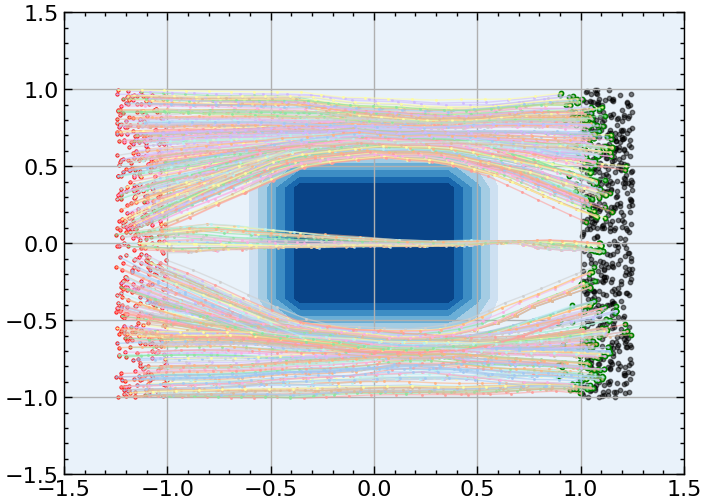

In [27]:
pi0 = next(data_loader)['src_lin']
pi1 = next(data_loader)['tgt_lin']

cost, trajs = noc.transport(pi0, n=20)

with plt.style.context(['science', 'notebook']):
    fig, ax = plt.subplots()
    countours = noc.flow.compute_potential(jnp.zeros_like(inp), inp) #jax.vmap(potential.apply, in_axes=(None, 0))(params_potential, inp)
    ax.contourf(xx, yy, countours.reshape(xx.shape), cmap="Blues")
    ax.scatter(pi0[:,0], pi0[:, 1], c='red', alpha=1, s=4)
    ax.scatter(pi1[:,0], pi1[:, 1], c='black', alpha=0.5, s=10)
    ax.scatter(trajs.x[-1][:, 0], trajs.x[-1][:, 1], c='green', s=10, label='pushforw')
    ax.set_xlim((-1.5, 1.5))
    ax.set_ylim((-1.5, 1.5))
    draw_trajs(trajs=trajs.x, ax=ax)
    plt.show()

In [28]:
potential = lagrangian_potentials.SlitPotential()
params_potential = potential.init(key, jnp.ones((2, )))

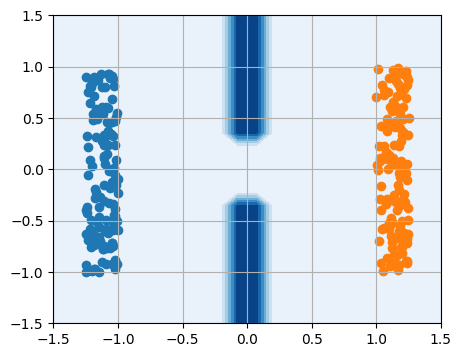

In [29]:
countours = jax.vmap(potential.apply, in_axes=(None, 0))(params_potential, inp)

fig, ax = plt.subplots(figsize=(5, 4))
source_data = next(source_sampler)
target_data = next(target_sampler)

plt.contourf(xx, yy, -countours.reshape(xx.shape), cmap="Blues")
ax.scatter(source_data[:, 0], source_data[:, 1])
ax.scatter(target_data[:, 0], target_data[:, 1])
plt.grid()
plt.show()

In [43]:
from ott.neural.methods.flows.dynamics import ConstantNoiseFlow, LagrangianFlow, BrownianBridge, LagrangianBridgeFlow
from ott.neural.methods.flows.nocc import NeuralOC
import flax.linen as nn
import optax

class MLP(nn.Module):
    hidden_layers: list
    
    @nn.compact
    def __call__(self, t, x, _):
        x = jnp.concatenate([x, t], -1)
        for i, dim in enumerate(self.hidden_layers):
            x = nn.Dense(dim)(x)
            if i != len(self.hidden_layers) - 1:
                x = nn.leaky_relu(x)
        return x

key = jax.random.PRNGKey(42)  
net = MLP(hidden_layers=[256, 256, 256, 1])
noc = NeuralOC(input_dim=2, value_model=net, optimizer=optax.adam(learning_rate=1e-6), potential_weight=800, flow=LagrangianFlow(sigma=0.2, potential=lagrangian_potentials.SlitPotential()), key=key)
data_loader = iter(DatasetLoader(512))

logs = noc(data_loader, n_iters=100_000, rng=key)

  0%|          | 0/100000 [00:00<?, ?it/s]

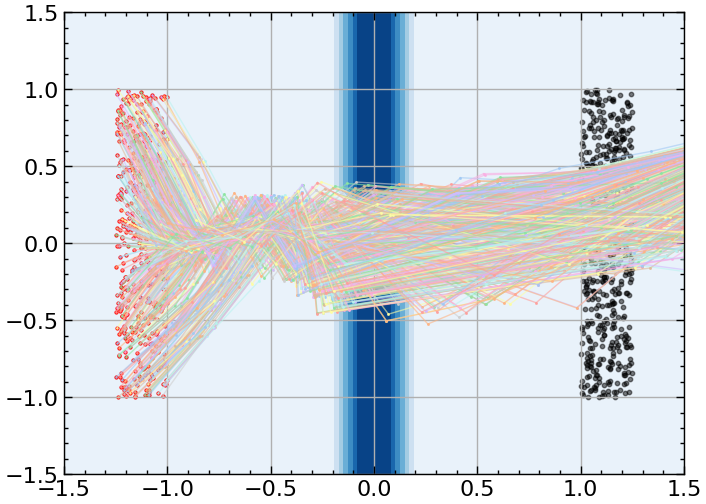

In [44]:
pi0 = next(data_loader)['src_lin']
pi1 = next(data_loader)['tgt_lin']

cost, trajs = noc.transport(pi0, n=10)

with plt.style.context(['science', 'notebook']):
    fig, ax = plt.subplots()
    countours = noc.flow.compute_potential(jnp.zeros_like(inp), inp) #jax.vmap(potential.apply, in_axes=(None, 0))(params_potential, inp)
    ax.contourf(xx, yy, countours.reshape(xx.shape), cmap="Blues")
    ax.scatter(pi0[:,0], pi0[:, 1], c='red', alpha=1, s=4, label='moons')
    ax.scatter(pi1[:,0], pi1[:, 1], c='black', alpha=0.5, s=10, label='gauss')
    ax.set_xlim((-1.5, 1.5))
    ax.set_ylim((-1.5, 1.5))
    draw_trajs(trajs=trajs.x, ax=ax)
    ax.legend()
    plt.show()

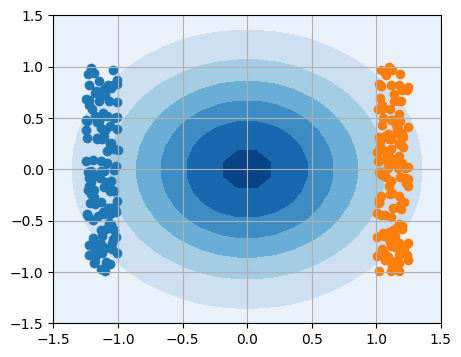

In [45]:
potential = lagrangian_potentials.HillPotential()
params_potential = potential.init(key, jnp.ones((2, )))

countours = jax.vmap(potential.apply, in_axes=(None, 0))(params_potential, inp)

fig, ax = plt.subplots(figsize=(5, 4))
source_data = next(source_sampler)
target_data = next(target_sampler)

plt.contourf(xx, yy, -countours.reshape(xx.shape), cmap="Blues")
ax.scatter(source_data[:, 0], source_data[:, 1])
ax.scatter(target_data[:, 0], target_data[:, 1])
plt.grid()
plt.show()

In [50]:
from ott.neural.methods.flows.dynamics import ConstantNoiseFlow, LagrangianFlow, BrownianBridge, LagrangianBridgeFlow
from ott.neural.methods.flows.nocc import NeuralOC
import flax.linen as nn
import optax

class MLP(nn.Module):
    hidden_layers: list
    
    @nn.compact
    def __call__(self, t, x, _):
        x = jnp.concatenate([x, t], -1)
        for i, dim in enumerate(self.hidden_layers):
            x = nn.Dense(dim)(x)
            if i != len(self.hidden_layers) - 1:
                x = nn.leaky_relu(x)
        return x

key = jax.random.PRNGKey(42)  
net = MLP(hidden_layers=[256, 256, 256, 1])
noc = NeuralOC(input_dim=2, value_model=net, optimizer=optax.adam(learning_rate=1e-6), potential_weight=600, flow=LagrangianFlow(sigma=0.01, potential=lagrangian_potentials.HillPotential()), key=key)
data_loader = iter(DatasetLoader(512))

logs = noc(data_loader, n_iters=100_000, rng=key)

  0%|          | 0/100000 [00:00<?, ?it/s]

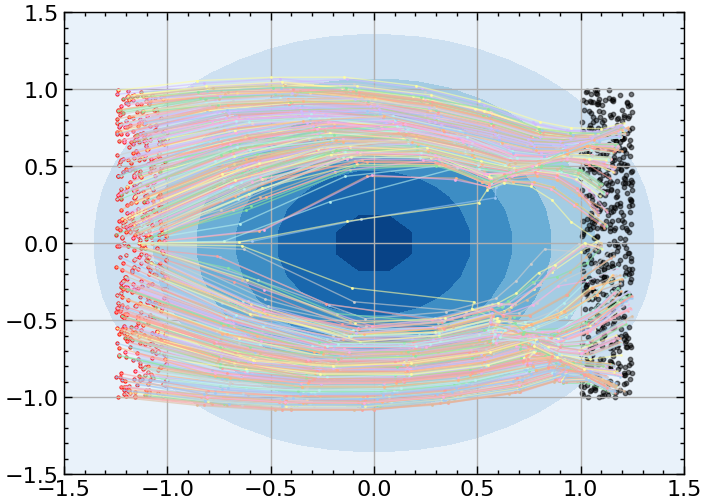

In [51]:
pi0 = next(data_loader)['src_lin']
pi1 = next(data_loader)['tgt_lin']

cost, trajs = noc.transport(pi0, n=10)

with plt.style.context(['science', 'notebook']):
    fig, ax = plt.subplots()
    countours = noc.flow.compute_potential(jnp.zeros_like(inp), inp) #jax.vmap(potential.apply, in_axes=(None, 0))(params_potential, inp)
    ax.contourf(xx, yy, countours.reshape(xx.shape), cmap="Blues")
    ax.scatter(pi0[:,0], pi0[:, 1], c='red', alpha=1, s=4, label='moons')
    ax.scatter(pi1[:,0], pi1[:, 1], c='black', alpha=0.5, s=10, label='gauss')
    ax.set_xlim((-1.5, 1.5))
    ax.set_ylim((-1.5, 1.5))
    draw_trajs(trajs=trajs.x, ax=ax)
    ax.legend()
    plt.show()